In [1]:
from collections import Counter
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

import string, re, os

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import logging, json

logging.basicConfig(
	format='%(asctime)s %(levelname)-8s %(message)s',
	level=logging.INFO,
	datefmt='%Y-%m-%d %H:%M:%S')

logger = logging


In [5]:
wnl = WordNetLemmatizer()
ps = PorterStemmer()

def lemmetizer_nva(text):
    text = wnl.lemmatize(text, pos='n')
    text = wnl.lemmatize(text, pos='v')
    text = wnl.lemmatize(text, pos='a')
    return text

def rm_suffix(word):
    word = ps.stem(word)
    return word

def replace_punctuation(text):
    punc = list(string.punctuation)
    for i in punc:
        text = text.replace(i, " ")
    return text

def rm_char_number(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove single characters
    text = re.sub(r'\b\w\b', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_user_defined_data(text):
    
    text = text.replace("’", "'")
    text = text.replace("‘", "'")
    text = text.replace("”", '"')
    text = text.replace("“", '"')
    text = text.replace("front-end", "frontend")
    text = text.replace("front end", "frontend")
    text = text.replace("back-end", "backend")
    text = text.replace("back end", "backend")
    text = text.replace("full-stack", "fullstack")
    text = text.replace("full stack", "fullstack")
    text = text.replace("sr", "senior")
    return text

def rm_stopwords(text):
    new_stopwords = stopwords.words('english') + ["able"]
    return " ".join([i for i in text.split(" ") if i not in new_stopwords])

In [6]:
class Preprocessing_Json_Jobs():
    def __init__(self):
        self.original_jobs = []
        self.base_input_file = "data/json_job_descriptions.txt"
        self.base_output = 'out'
        self.all_jobs = []
        self.dict_keywords = Counter()
        self.most_common_words = []

    def parse_job_descriptions(self, file_path):
        with open(file_path, 'r') as file:
            content = file.read()
        
        # Split the content into individual JSON objects
        json_objects = content.split('```json')
        
        parsed_jobs = []
        for job_string in json_objects:
            if job_string.strip():
                # Remove any leading/trailing whitespace and backticks
                job_string = job_string.strip().strip('`')
                try:
                    job_data = json.loads(job_string)
                    parsed_jobs.append(job_data)
                except json.JSONDecodeError:
                    logger.warning(f"Failed to parse JSON: {job_string[:50]}...")
        
        return parsed_jobs
    
    def getOriginJSONData(self):
        job_descriptions = self.parse_job_descriptions(self.base_input_file)

        for job in job_descriptions:
            # Extract relevant fields
            position = job['job_position']
            responsibilities = ' '.join(job['responsibilities'])
            required_skills = ' '.join(job['required_skills'])
            nice_to_have_skills = ' '.join(job['nice_to_have_skills'])

            MULTI = 3
            multi_required_skills = list(set(job['required_skills']))
            multi_required_skills = " ".join([" ".join([i] * MULTI) for i in multi_required_skills])
            
            # Combine all text
            combined_text = f"{position} {responsibilities} {multi_required_skills} {nice_to_have_skills}"

            self.original_jobs.append(combined_text)
    
    def getALLJSONData(self):
        self.getOriginJSONData()
        
        for job in self.original_jobs:
            job = job.lower()
            rm_user_defined_data_job =  clean_user_defined_data(job)
            rm_punctuation_job =        replace_punctuation(rm_user_defined_data_job)
            rm_enter_job =              " ".join([i for i in rm_punctuation_job.split("\n") if i != ""])
            rm_multiple_space_job =     " ".join([i for i in rm_enter_job.split(" ") if i != ""])
            rm_stopwords_job =          rm_stopwords(rm_multiple_space_job)
            lemmertize_job =            " ".join([rm_suffix(lemmetizer_nva(i)) for i in rm_stopwords_job.split(" ")])
            rm_char_number_job =        rm_char_number(lemmertize_job)

            self.dict_keywords.update(Counter(rm_char_number_job.split(" ")))
            self.all_jobs.append(rm_char_number_job)

    def preprocessing(self):
        self.getALLJSONData()

    
    def get_most_common_words(self, clusters, prediction, MC_num):
        for i in range(clusters):
            self.most_common_words.append(Counter())

        for idx, value in enumerate(self.all_jobs):
            self.most_common_words[prediction[idx]].update(Counter(value.split()))
        

        ret_most_common_words = [i.most_common(MC_num) if len(i) >= MC_num else i for i in self.most_common_words if i != Counter()]

        return ret_most_common_words


JJ = Preprocessing_Json_Jobs()
JJ.preprocessing()
JJ.all_jobs[:5]

2024-08-26 06:33:01 WARNING  Failed to parse JSON: {
  "job_position": "Senior Front End Developer",
...
2024-08-26 06:33:01 WARNING  Failed to parse JSON: {
  "job_position": "Software Programmer",
  "resp...


['senior ui design frontend develop understand analyz user need translat intuit compel ui design creat wirefram demonstr function differ user interact lead ui design process web interfac ensur seamless intuit user experi confid guid design implement ui implement ui design web applic use html cs javascript svelt svelt svelt svelt commun commun commun ajax ajax ajax collabor collabor collabor design design design sketch sketch sketch figma figma figma cs cs cs critic think critic think critic think usabl usabl usabl json json json adob xd adob xd adob xd javascript javascript javascript html html html tailwind',
 'senior softwar engin develop softwar use python fastapi javascript react aw implement tdd autom test ensur softwar qualiti creat design diagram particip technic discuss convey system design perform threat model implement secur measur throughout develop lifecycl engag project team stakehold daili standup sprint plan custom demo session linux linux linux rest rest rest docker doc

In [8]:
class Preprocessing_Job_Descriptions():
    def __init__(self):
        self.original_jobs = ""
        self.base_input_file = "job_descriptions.txt"
        self.base_output = 'out'
        self.all_jobs = []
        self.dict_keywords = Counter()

    def getAllJobs(self):
        with open(self.base_input_file, "r") as f:
            self.original_jobs = f.read()
            self.original_jobs = [i for i in self.original_jobs.split("}}}") if i  != ""]
            self.original_jobs = [i.replace("{{{", "") for i in self.original_jobs]

        for job in self.original_jobs:
            job = job.lower()
            rm_user_defined_data_job =  clean_user_defined_data(job)
            rm_punctuation_job =        replace_punctuation(rm_user_defined_data_job)
            rm_enter_job =              " ".join([i for i in rm_punctuation_job.split("\n") if i != ""])
            rm_multiple_space_job =     " ".join([i for i in rm_enter_job.split(" ") if i != ""])
            rm_stopwords_job =          rm_stopwords(rm_multiple_space_job)
            lemmertize_job =            " ".join([rm_suffix(lemmetizer_nva(i)) for i in rm_stopwords_job.split(" ")])
            rm_char_number_job =        rm_char_number(lemmertize_job)

            self.dict_keywords.update(Counter(rm_char_number_job.split(" ")))
            self.all_jobs.append(rm_char_number_job)

    def preprocessing(self):
        self.getAllJobs()


J = Preprocessing_Job_Descriptions()
J.preprocessing()

print(f'The number of All jobs is {len(J.all_jobs)}')
print(f'The number of dict keywords is {len(J.dict_keywords)}')
J.all_jobs[:5]

The number of All jobs is 322
The number of dict keywords is 3662


['job senior ui design frontend develop gener descript look skill frontend engin develop frontend applic collabor backend engin role involv creat user interfac simplifi workflow accommod complex busi process valid requir backend handl busi logic candid must understand rule repres effect frontend posit requir proactiv individu manag time independ within agil kanban framework minim day day supervis candid deliv code frequent possibl ensur applic meet need intern oper busi staff respons understand analyz user need translat intuit compel ui design creat wirefram demonstr function differ user interact lead ui design process web interfac ensur seamless intuit user experi confid guid design implement ui implement ui design web applic use html cs javascript svelt skill profici creat interact prototyp use design tool figma sketch adob xd similar familiar desktop spa web applic profici html cs javascript svelt tailwind experi json ajax api call excel commun collabor skill abil think critic solv 

In [7]:
class Preprocessing_C1_C4_C7():
    def __init__(self):
        self.base_input = "data/"
        self.base_output = "out/"
        self.dict_keywords = Counter()
        self.all_jobs = []
        self.all_input_paths = []

    def getAllInputPath(self, input_data_path):
        for subdir in os.listdir(input_data_path):
            new_path = input_data_path + subdir
            if new_path.endswith(".txt"):
                self.all_input_paths.append(new_path)
            elif os.path.isdir(new_path):
                self.getAllInputPath(new_path + "/")

        return self.all_input_paths 
    
    def getAllInputData(self):
        for path in self.all_input_paths:
            # print(path)
            with open(path, "r") as f:
                data = f.read()
                data = data.lower()

                # print(data)

                rm_user_defined_data_job =  clean_user_defined_data(data)
                rm_punctuation_job =        replace_punctuation(rm_user_defined_data_job)
                rm_enter_job =              " ".join([i for i in rm_punctuation_job.split("\n") if i != ""])
                rm_multiple_space_job =     " ".join([i for i in rm_enter_job.split(" ") if i != ""])
                rm_stopwords_job =          " ".join([i for i in rm_multiple_space_job.split(" ") if i not in stopwords.words("english")])
                lemmertize_job =            " ".join([lemmetizer_nva(i) for i in rm_stopwords_job.split(" ")])
                rm_char_number_job =        rm_char_number(lemmertize_job)

                self.dict_keywords.update(Counter(rm_char_number_job.split(" ")))
                self.all_jobs.append(rm_char_number_job)

    def preprocessing(self):
        self.getAllInputPath(self.base_input)
        
        if self.all_input_paths == None or self.all_input_paths == []:
            print("No input data. Input correct Data file paths")
            return "No input data. Input correct Data file paths"
        self.getAllInputData()

C147 = Preprocessing_C1_C4_C7()
C147.preprocessing()
C147.all_jobs[:5]

['aviation authority grind airline safety concern unprecedented move local commercial aviation history government decide suspend operation colombian airline belief airline meet aviation standard guarantee safety fact civil aeronautics administrative directorate notify aerorepublica airline currently rank third country start today cannot fly nine dc jet make fleet jet remain ground least two week aerorepublica supply civil aeronautics paperwork document contain record jet engine buy alitalia company four year ago accord civil aeronautics director abel enrique jimenez neira colombian airline achieve aviation certification already grant avianca ace tampa long aerorepublica unable meet standard must wait bar fly concern safety pas inspection jimenez neira say official note key issue prompt drastic measure fact aerorepublica record jet airline possibility fly three nine jet depend result inspection civil aeronautics inspector plan make next four day three jet check aerorepublica able supply

In [38]:
# Input_X = J.all_jobs
Input_X = JJ.all_jobs
# Input_X = C147.all_jobs

tfidfvectorizer = TfidfVectorizer(max_df=0.7, min_df=0.05, ngram_range=(1, 2))
X = tfidfvectorizer.fit_transform(Input_X)

TF_IDF_X = pd.DataFrame(X.toarray(), columns=tfidfvectorizer.get_feature_names_out())
TF_IDF_X

,access,account,across,activ,adher,agil,agil agil,align,analyt,analyz,...,web applic,web develop,websit,well,well document,within,work,work close,write,write clean
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.121459,...,0.086970,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,0.0,0.0,0.000000,0.000000,0.093793,0.000000,0.0,0.108912,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.068739,0.0
4,0.0,0.0,0.000000,0.000000,0.000000,0.082076,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,0.0,0.0,0.000000,0.000000,0.000000,0.055036,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.040443,0.000000,0.000000,0.0
410,0.0,0.0,0.120819,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.124548,0.000000,0.000000,0.0
411,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.144438,0.000000,0.000000,0.000000,0.0
412,0.0,0.0,0.083155,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.067632,0.0,0.280908,0.0,0.0,0.000000,0.171443,0.139658,0.000000,0.0


In [37]:
with open(f'{JJ.base_output}/keywords.csv', 'w') as f:
    for i in list(TF_IDF_X):
        f.write(i + '\n')


In [23]:
print(len(JJ.all_jobs))
print(len(JJ.dict_keywords))

414
2205


[331.3120490553676, 321.73345633524394, 313.520975209915, 307.45283000619384, 302.0626138826854, 297.69978495046263, 292.92496349950085, 288.35808566777047]


c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows wi

[1563.3074996816563, 1441.6469664942224, 1356.2315340378866, 1276.3674999306245, 1221.4059302221008, 1176.3230716554406, 1144.2005360976164, 1108.4709526873582]


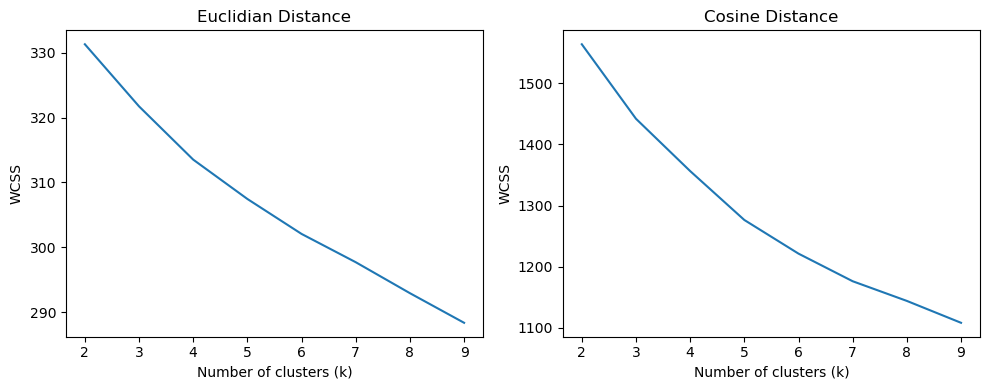

In [39]:
# Clustering K-Means
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


MAX_CLUSTERS = 10
MAX_ITER = 3000
cosine_sim_X = cosine_similarity(X)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


def euclidian_k_means():

    wcss = []

    for i in range(2, MAX_CLUSTERS):
        kmeans = KMeans(n_clusters=i, max_iter=MAX_ITER, random_state=30, n_init=50)
        kmeans.fit(X=X)
        wcss.append(kmeans.inertia_)

    print(wcss)

    ax1.plot(range(2, MAX_CLUSTERS), wcss)
    ax1.set_xticks(range(2, MAX_CLUSTERS))
    ax1.set_xlabel('Number of clusters (k)')
    ax1.set_ylabel('WCSS')
    ax1.set_title('Euclidian Distance')

def cosine_sim_k_means():
    
    wcss = []

    for i in range(2, MAX_CLUSTERS):
      kmeans = KMeans(n_clusters = i, max_iter = MAX_ITER, random_state=40, n_init=50)
      kmeans.fit(X=cosine_sim_X)
      wcss.append(kmeans.inertia_)


    print(wcss)

    ax2.plot(range(2, MAX_CLUSTERS), wcss)
    ax2.set_xticks(range(2, MAX_CLUSTERS))
    ax2.set_xlabel('Number of clusters (k)')
    ax2.set_ylabel('WCSS')
    ax2.set_title('Cosine Distance')


euclidian_k_means()
cosine_sim_k_means()

plt.tight_layout()
plt.show()

c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


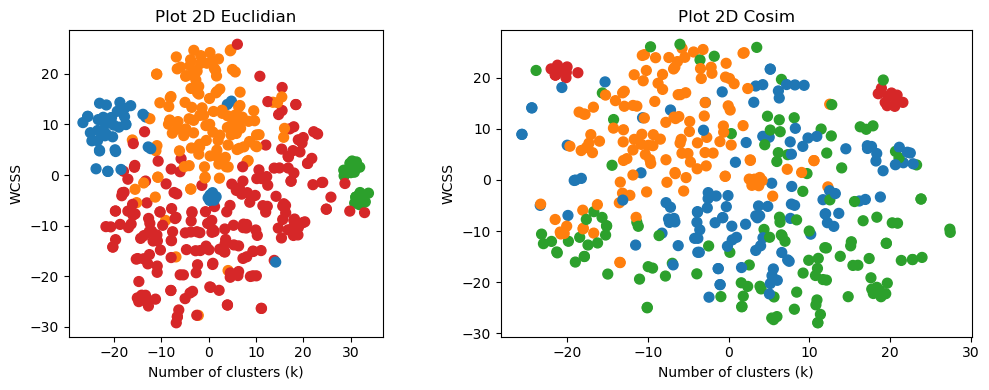

In [40]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

Tradeoff_Clusters = 4

colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
    '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78',
    '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7',
    '#dbdb8d', '#9edae5'
]

colors = colors[:Tradeoff_Clusters]

figure_plot = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3])

# Fuguring Data J, JJ, C147
# figure_Data = J.all_jobs
figure_Data = JJ.all_jobs
# figure_Data = C147.all_jobs

plot_euclidian_2d = figure_plot.add_subplot(gs[0, 0])
# plot_euclidian_3d = figure_plot.add_subplot(gs[0, 1], projection='3d')
plot_cosine_2d = figure_plot.add_subplot(gs[0,1])
# plot_cosine_3d = figure_plot.add_subplot(gs[1, 1], projection='3d')


def euclidean_tsne():
    kmeans = KMeans(n_clusters = Tradeoff_Clusters, max_iter = MAX_ITER, random_state=30, n_init=50)
    predictions = kmeans.fit_predict(X=X)

    # Ensure we have enough colors for all clusters
    color_map = np.array(colors)[predictions % len(colors)]
    perplexity = min(30, len(figure_Data) - 1)

    # Apply t-SNE for 2D
    tsne = TSNE(n_components=2, init='random', perplexity=perplexity, random_state=30)
    tsne_2D_results = tsne.fit_transform(X)

    # Apply t-SNE for 3D
    tsne = TSNE(n_components=3, init='random', perplexity=perplexity, random_state=30)
    tsne_3D_results = tsne.fit_transform(X)

    # Visualize 2D plot
    plot_euclidian_2d.scatter(tsne_2D_results[:, 0], tsne_2D_results[:, 1], c=color_map, s=50)
    plot_euclidian_2d.set_title('Plot 2D Euclidian')
    plot_euclidian_2d.set_xlabel('Number of clusters (k)')
    plot_euclidian_2d.set_ylabel('WCSS')


    # # Visualize the results with custom colors using 3D
    # plot_euclidian_3d.scatter(tsne_3D_results[:, 0], tsne_3D_results[:, 1], tsne_3D_results[:, 2], c=color_map)
    # plot_euclidian_3d.set_title('Plot 3D Euclidian')
    # plot_euclidian_3d.set_xlabel('t-SNE feature 1')
    # plot_euclidian_3d.set_ylabel('t-SNE feature 2')
    # # tsne_plot_euclidian.set('t-SNE feature 3')

    # # Add a legend
    # for i, color in enumerate(colors):
    #     plot_euclidian_3d.scatter([], [], c=color, label=f'Cluster {i}')
    # plot_euclidian_3d.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    return predictions


def cosine_sim_tsne():
    kmeans = KMeans(n_clusters = Tradeoff_Clusters, max_iter = MAX_ITER, random_state=40, n_init=50)
    predictions = kmeans.fit_predict(X=cosine_sim_X)

    # Ensure we have enough colors for all clusters
    color_map = np.array(colors)[predictions % len(colors)]
    perplexity = min(30, len(figure_Data) - 1)

    # Apply t-SNE for 2D
    tsne = TSNE(n_components=2, init='random', perplexity=perplexity, random_state=40)
    tsne_2D_results = tsne.fit_transform(X)

    # Apply t-SNE for 3D
    tsne = TSNE(n_components=3, init='random', perplexity=perplexity, random_state=40)
    tsne_3D_results = tsne.fit_transform(X)

    # Visualize 2D plot
    plot_cosine_2d.scatter(tsne_2D_results[:, 0], tsne_2D_results[:, 1], c=color_map, s=50)
    plot_cosine_2d.set_title('Plot 2D Cosim')
    plot_cosine_2d.set_xlabel('Number of clusters (k)')
    plot_cosine_2d.set_ylabel('WCSS')

    # # Visualize the results with custom colors using 3D
    # plot_cosine_3d.scatter(tsne_3D_results[:, 0], tsne_3D_results[:, 1], tsne_3D_results[:, 2], c=color_map)
    # plot_cosine_3d.scatter(tsne_3D_results[:, 0], tsne_3D_results[:, 1], c=color_map)
    # plot_cosine_3d.set_title('Plot 3D Cosim')
    # plot_cosine_3d.set_xlabel('t-SNE feature 1')
    # plot_cosine_3d.set_ylabel('t-SNE feature 2')
    # # tsne_plot_cosine.set_zorder('t-SNE feature 3')

    # # Add a legend
    # for i, color in enumerate(colors):
    #     plot_cosine_3d.scatter([], [], c=color, label=f'Cluster {i}')
    # plot_cosine_3d.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    return predictions


predictions_euclidian = euclidean_tsne()
predictions_cosine = cosine_sim_tsne()

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

plt.show()

In [45]:
import os


def make_out_dir():
    set_ir = set(predictions_euclidian + 1)
    for i in set_ir:
        if os.path.exists(f'{JJ.base_output}/job{i}'):
            pass
        else:
            os.makedirs(f'{JJ.base_output}/job{i}')
    
    for idx, value in enumerate(list(predictions_euclidian + 1)):
        with open(f'{JJ.base_output}/job{value}/{idx}.txt', 'w') as f:
            f.write(JJ.original_jobs[idx])
            print(f'Successfully saved {JJ.base_output}/job{value}/{idx}.txt !!!!!!')

make_out_dir()


Successfully saved out/job8/0.txt !!!!!!
Successfully saved out/job3/1.txt !!!!!!
Successfully saved out/job6/2.txt !!!!!!
Successfully saved out/job4/3.txt !!!!!!
Successfully saved out/job3/4.txt !!!!!!
Successfully saved out/job1/5.txt !!!!!!
Successfully saved out/job3/6.txt !!!!!!
Successfully saved out/job1/7.txt !!!!!!
Successfully saved out/job1/8.txt !!!!!!
Successfully saved out/job1/9.txt !!!!!!
Successfully saved out/job8/10.txt !!!!!!
Successfully saved out/job5/11.txt !!!!!!
Successfully saved out/job6/12.txt !!!!!!
Successfully saved out/job4/13.txt !!!!!!
Successfully saved out/job1/14.txt !!!!!!
Successfully saved out/job1/15.txt !!!!!!
Successfully saved out/job3/16.txt !!!!!!
Successfully saved out/job8/17.txt !!!!!!
Successfully saved out/job8/18.txt !!!!!!
Successfully saved out/job6/19.txt !!!!!!
Successfully saved out/job3/20.txt !!!!!!
Successfully saved out/job3/21.txt !!!!!!
Successfully saved out/job7/22.txt !!!!!!
Successfully saved out/job6/23.txt !!!!!!
Su

In [ ]:
def filter_dict_keywords_jobs(threshold, keywords, jobs):
    keywords = dict(keywords.most_common(len(keywords)))
    threshold_sum = sum(keywords.values()) * threshold

    ret_dict_keywords = {}
    ret_jobs = []
    ret_sum = 0

    for key, value in keywords.items():
        ret_sum += value
        if ret_sum <= threshold_sum:
            ret_dict_keywords[key] = value
        else:
            break
    
    ret_dict_keywords_key = ret_dict_keywords.keys()

    for job in jobs:
        job = " ".join([i for i in job.split(" ") if i in ret_dict_keywords_key])
        ret_jobs.append(job)

    return ret_dict_keywords, ret_jobs
        
new_dict_keywords, new_all_jobs = filter_dict_keywords_jobs(0.8, C147.dict_keywords, C147.all_jobs)

print(len(C147.dict_keywords))
print(len(new_dict_keywords))

In [52]:
print(predictions_euclidian + 1, len(predictions_euclidian))
print(len(JJ.all_jobs))
JJ.all_jobs[:5]

[8 3 6 4 3 1 3 1 1 1 8 5 6 4 1 1 3 8 8 6 3 3 7 6 3 1 6 3 1 7 1 8 6 3 7 3 4
 8 7 7 1 1 7 3 3 6 7 3 3 3 6 1 1 6 1 1 3 7 3 3 3 3 1 3 7 8 3 3 3 3 4 2 2 4
 4 3 3 1 2 4 6 1 7 6 1 7 4 2 3 7 5 3 6 4 4 3 7 4 3 4 3 1 3 5 7 3 7 6 4 7 5
 5 2 6 8 3 2 1 1 1 7 3 1 1 3 4 6 6 4 4 5 3 2 2 3 4 7 7 4 3 1 1 6 1 6 3 1 1
 3 2 3 2 3 4 1 6 8 7 4 3 3 1 3 3 3 8 3 8 7 2 2 3 3 2 4 3 3 3 8 8 3 6 3 1 3
 8 5 1 4 8 2 3 2 1 3 4 3 8 3 1 3 3 1 3 1 1 2 4 3 5 2 3 3 4 7 5 3 7 8 3 3 3
 1 2 3 3 3 4 3 8 3 6 6 8 4 3 3 6 6 8 5 8 3 1 1 4 3 4 5 1 3 4 3 3 7 3 3 3 3
 6 7 4 1 5 1 7 1 6 7 1 4 1 1 8 8 4 4 8 1 1 1 7 1 1 7 1 1 1 1 6 8 1 4 7 4 1
 1 8 1 4 8 1 4 3 3 6 3 2 3 7 3 2 3 8 7 5 1 3 6 5 3 5 3 6 3 6 1 3 7 1 3 7 4
 4 1 4 3 3 1 3 1 7 7 3 7 1 6 7 3 4 3 4 3 7 7 4 4 3 3 3 1 1 1 1 1 4 3 3 3 3
 6 3 5 3 4 3 4 4 4 3 7 1 3 1 8 3 3 7 1 3 3 3 3 8 1 3 6 3 4 3 1 3 6 3 3 3 3
 6 1 3 3 3 1 3] 414
414


['senior ui design frontend develop understand analyz user need translat intuit compel ui design creat wirefram demonstr function differ user interact lead ui design process web interfac ensur seamless intuit user experi confid guid design implement ui implement ui design web applic use html cs javascript svelt usabl usabl usabl cs cs cs svelt svelt svelt javascript javascript javascript json json json ajax ajax ajax critic think critic think critic think sketch sketch sketch adob xd adob xd adob xd design design design collabor collabor collabor html html html figma figma figma commun commun commun tailwind',
 'sr softwar engin develop softwar use python fastapi javascript react aw implement tdd autom test ensur softwar qualiti creat design diagram particip technic discuss convey system design perform threat model implement secur measur throughout develop lifecycl engag project team stakehold daili standup sprint plan custom demo session aw aw aw react react react docker docker docker

In [65]:
most_common_words_per_job = JJ.get_most_common_words(Tradeoff_Clusters, predictions_euclidian, 50)

for idx, value in enumerate(most_common_words_per_job):
    with open(f'./{JJ.base_output}/most_common_words_per_job_{idx + 1}.txt', 'w') as f:
        for i in value:
            f.write(f'{i}\n')